# 🤖 1. Import thư viện

In [1]:
# Import libraries
import os
import torch
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Any, Dict, List

from datasets import load_dataset, Audio, concatenate_datasets
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType

In [2]:
from huggingface_hub import notebook_login
notebook_login()

MODEL_ID = "openai/whisper-small"
OUTPUT_DIR = "./models/whisper_de_finetune"
CACHE_DIR = os.path.expanduser("~/.cache/huggingface")

In [3]:
from datasets import load_dataset, Audio
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Load dataset
common_voice = load_dataset(
    "mozilla-foundation/common_voice_13_0",
    "de",
    cache_dir=CACHE_DIR,
    trust_remote_code=True,   # ✅ thêm dòng này
    split={
        "train": "train[:10%]",
        "validation": "validation[:10%]",
        "test": "test[:10%]"
    }
)

# Resample audio
for split in ["train", "validation", "test"]:
    common_voice[split] = common_voice[split].cast_column("audio", Audio(sampling_rate=16000))

# Load model + processor
processor = WhisperProcessor.from_pretrained(MODEL_ID, language="de", task="transcribe", cache_dir=CACHE_DIR)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID, cache_dir=CACHE_DIR)
model.freeze_encoder()   # khóa encoder để giảm số tham số cần train

In [4]:
from datasets import load_dataset

print(common_voice)
print("Dataset cached at:", common_voice.cache_files)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 54044
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 1614
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 1614
    })
})
Dataset cached at: {'train': [{'filename': '/Users/vietphung/.cache/huggingface/mozilla-foundation___common_voice_13_0/de/13.0.0/2506e9a8950f5807ceae08c2920e814222909fd7f477b74f5d225802e9f04055/common_voice_13_0-train.arrow'}], 'validation': [{'filename': '/Users/vietphung/.cache/huggingface/mozilla-foundation___common_voice_13_0/de/13.0.0/2506e9a8950f5807ceae08c2920e814222909fd7f4

In [5]:
# Take a random sample from the training set
sample = common_voice["train"][0]
print(sample)

# ▶️ Play the audio file directly inside Jupyter Notebook
import IPython.display as ipd
ipd.Audio(sample["audio"]["array"], rate=sample["audio"]["sampling_rate"])

{'client_id': '2a2542c35dd80feb743539a32e8c856a4bfce196ae633b0d71c4c4d1b988720c795a9c3f8c38a0af7ba9e366e6431527688cc21c8bb5c88f437c311ce518b51b', 'path': '/Users/vietphung/.cache/huggingface/downloads/extracted/4411fd7718fbccd84e4c91d664f30afa1ab4b843252733e6dc8f12ecce391a4b/de_train_0/common_voice_de_19130994.mp3', 'audio': {'path': '/Users/vietphung/.cache/huggingface/downloads/extracted/4411fd7718fbccd84e4c91d664f30afa1ab4b843252733e6dc8f12ecce391a4b/de_train_0/common_voice_de_19130994.mp3', 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       2.90568619e-06, 4.44464149e-06, 7.46920705e-06]), 'sampling_rate': 16000}, 'sentence': 'Damit war das erklärte Ziel des Teams verfehlt.', 'up_votes': 2, 'down_votes': 0, 'age': '', 'gender': '', 'accent': '', 'locale': 'de', 'segment': '', 'variant': ''}


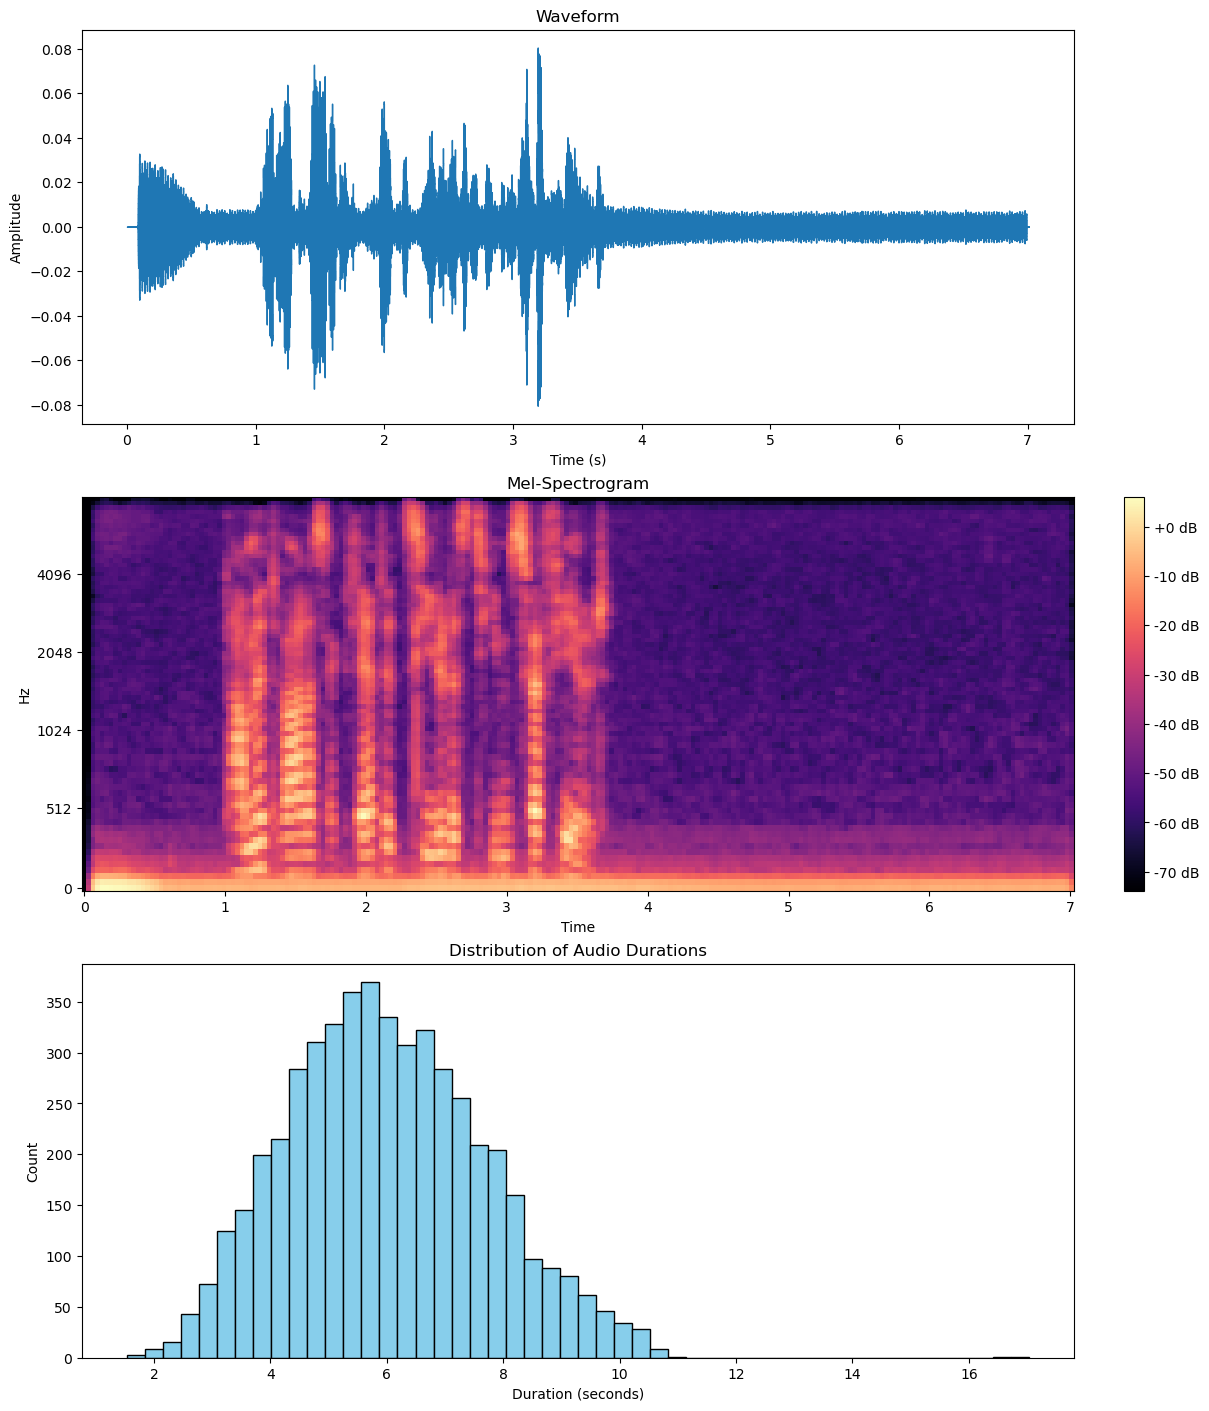

Transcript: Damit war das erklärte Ziel des Teams verfehlt.


In [7]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd

# Select one sample to visualize
sample = common_voice["train"][0]
audio = sample["audio"]["array"]
sr = sample["audio"]["sampling_rate"]
transcript = sample["sentence"]

# Compute durations for a subset of the dataset
durations = [
    len(x["audio"]["array"]) / x["audio"]["sampling_rate"]
    for x in common_voice["train"].select(range(5000))
]

# Create figure with 3 rows
fig, axs = plt.subplots(3, 1, figsize=(12, 14), constrained_layout=True)

# 1. Waveform
librosa.display.waveshow(audio, sr=sr, ax=axs[0])
axs[0].set_title("Waveform")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Amplitude")

# 2. Mel-Spectrogram
melspec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=80)
log_melspec = librosa.power_to_db(melspec)
img = librosa.display.specshow(log_melspec, sr=sr, x_axis="time", y_axis="mel", ax=axs[1])
axs[1].set_title("Mel-Spectrogram")
fig.colorbar(img, ax=axs[1], format="%+2.0f dB")

# 3. Histogram of audio durations
axs[2].hist(durations, bins=50, color="skyblue", edgecolor="black")
axs[2].set_title("Distribution of Audio Durations")
axs[2].set_xlabel("Duration (seconds)")
axs[2].set_ylabel("Count")

plt.show()

# Listen to the selected sample
print("Transcript:", transcript)
ipd.display(ipd.Audio(audio, rate=sr))

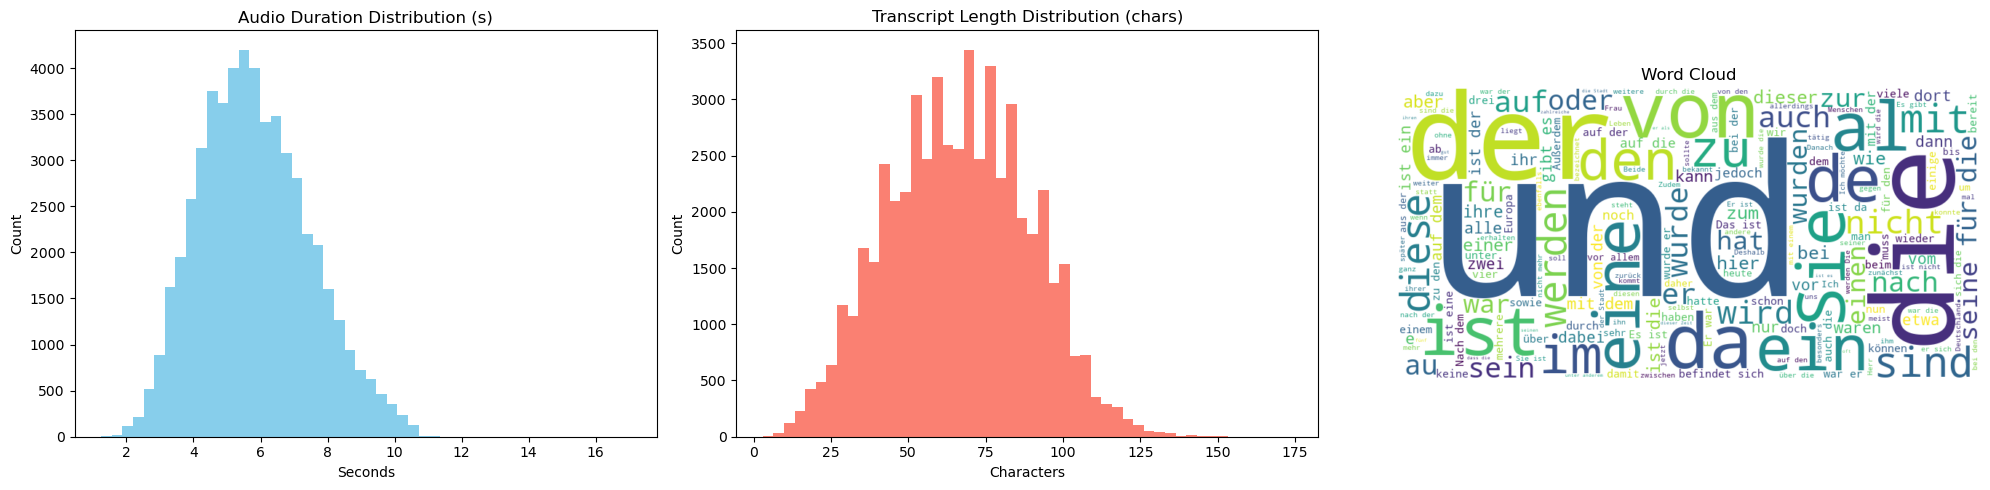

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud

# Get training data
train_data = common_voice["train"]

# 1. Histogram of audio durations
durations = [len(x["array"]) / x["sampling_rate"] for x in train_data["audio"]]

# 2. Histogram of transcript lengths
transcript_lengths = [len(t) for t in train_data["sentence"] if t is not None]

# 3. WordCloud from all transcripts
all_text = " ".join([t for t in train_data["sentence"] if t is not None])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_text)

# --- Plot 3 visualizations ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot 1: Audio duration distribution
axes[0].hist(durations, bins=50, color="skyblue")
axes[0].set_title("Audio Duration Distribution (s)")
axes[0].set_xlabel("Seconds")
axes[0].set_ylabel("Count")

# Plot 2: Transcript length distribution
axes[1].hist(transcript_lengths, bins=50, color="salmon")
axes[1].set_title("Transcript Length Distribution (chars)")
axes[1].set_xlabel("Characters")
axes[1].set_ylabel("Count")

# Plot 3: WordCloud
axes[2].imshow(wordcloud, interpolation="bilinear")
axes[2].axis("off")
axes[2].set_title("Word Cloud")

plt.tight_layout()
plt.show()

In [11]:
def preprocess(batch):
    audio = batch["audio"]
    inputs = processor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        text=batch["sentence"],
        return_tensors="pt"
    )
    batch["input_features"] = inputs.input_features[0]
    batch["labels"] = inputs.labels[0]
    return batch

common_voice = common_voice.map(
    preprocess,
    remove_columns=common_voice["train"].column_names,
    num_proc=4
)

Map (num_proc=4):   0%|          | 0/54044 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1614 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1614 [00:00<?, ? examples/s]

In [21]:
from dataclasses import dataclass
from typing import Any, Dict, List

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: WhisperProcessor
    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_feats = [{"input_features": f["input_features"]} for f in features]
        label_feats = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.feature_extractor.pad(input_feats, return_tensors="pt")
        labels_batch = self.processor.tokenizer.pad(label_feats, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )
        batch["labels"] = labels
        return batch

data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [54]:
from transformers import WhisperForConditionalGeneration
from peft import LoraConfig, get_peft_model

# 1. Load Whisper gốc
from peft import PeftModel

class WhisperTuner(PeftModel):
    def __init__(self, model, peft_config, adapter_name="default"):
        super().__init__(model, peft_config, adapter_name)
        self.base_model_prepare_inputs_for_generation = self.base_model.prepare_inputs_for_generation
        self.base_model_prepare_encoder_decoder_kwargs_for_generation = (
            self.base_model._prepare_encoder_decoder_kwargs_for_generation
        )

    def forward(
        self,
        attention_mask=None,
        decoder_input_ids=None,
        decoder_attention_mask=None,
        decoder_inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        task_ids=None,
        **kwargs,
    ):
        return self.base_model(
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            decoder_inputs_embeds=decoder_inputs_embeds,
            labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

# 2. Định nghĩa LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],  # các layer cần chèn LoRA
    lora_dropout=0.05,
    bias="none",
    task_type="SEQ_2_SEQ_LM"              # bắt buộc cho Seq2Seq
)

# 3. Wrap model bằng LoRA (chuẩn)
model = get_peft_model(model, lora_config)

# 4. In số tham số trainable (kiểm tra)
model.print_trainable_parameters()

trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


In [55]:
import evaluate

# Load metrics
wer = evaluate.load("wer")
cer = evaluate.load("cer")
bertscore = evaluate.load("bertscore")

def compute_metrics(pred):
    # Giải mã dự đoán và nhãn
    pred_str = processor.batch_decode(pred.predictions, skip_special_tokens=True)
    label_str = processor.batch_decode(pred.label_ids, skip_special_tokens=True)

    # Tính từng chỉ số
    wer_score = wer.compute(predictions=pred_str, references=label_str)
    cer_score = cer.compute(predictions=pred_str, references=label_str)
    bert_score = bertscore.compute(predictions=pred_str, references=label_str, lang="de")

    return {
        "wer": wer_score,
        "cer": cer_score,
        "bertscore_f1": float(np.mean(bert_score["f1"]))
    }

In [56]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import os

# Chặn accelerate ép mixed precision
os.environ["ACCELERATE_MIXED_PRECISION"] = "no"

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-lora-commonvoice",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    eval_strategy="steps",   # ✅ dùng đúng tên
    save_strategy="steps",
    save_steps=500,
    eval_steps=500,
    logging_steps=100,
    learning_rate=1e-4,
    num_train_epochs=5,
    warmup_steps=500,
    gradient_checkpointing=True,
    fp16=False,
    bf16=False,                    # ✅ thêm để tránh lỗi MPS
    save_total_limit=2,
    predict_with_generate=True,
    push_to_hub=False
)

class WhisperSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(
            input_features=inputs["input_features"],
            labels=inputs["labels"]
        )
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

trainer = WhisperSeq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=common_voice["train"],
    eval_dataset=common_voice["validation"],
    data_collator=data_collator,
    processing_class=processor,
    compute_metrics=compute_metrics
)

trainer.train()
results = trainer.evaluate(eval_dataset=common_voice["test"])
print("Final evaluation:", results)

TypeError: WhisperForConditionalGeneration.forward() got an unexpected keyword argument 'input_ids'